## Table of contents

1. [Data overview](#data_overview)    
    1. [Performance of the top models](#performance)     
    2. [Finding the best subset](#finding)      
2. [Fine-tuning hyperparameters](#hyperparameters)    
3. [Reconstructing the top models](#reconstructing)    
    1. [ROC curves](#roc_curves)    
4. [Supplementary data](#supplementary)    
    1. [Comparing classifiers](#comparing)    
    2. [Performance of the top models](#top_classifiers)     
    3. [Docking scores and performance increment](#docking)    
    4. [Top descriptors](#top_descriptors)    
    5. [Saving the top 3 models](#saving)     
    
<a id='scoring_metrics'></a>
### Scoring metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read data
data = pd.read_csv('data.csv')

# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Descriptors
descriptors_list = list(descriptors.columns[2:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']
trainset = descriptors_list + docking_list

# Test metrics
scoring_metrics = ['test_accuracy','test_precision','test_recall','test_f1','test_f2',
                   'test_geometric_mean','test_roc_auc']
columns = ['activity_label', 'model', 'random_state', scoring_metrics] + trainset

<a id='data_overview'></a>
## Data overview

In [3]:
# Read test scores and sort values
scores_data = pd.read_csv('scores_data_KFold.csv.gz', compression='gzip')

model_list = scores_data['model'].unique()
columns = scores_data.columns
selected = ['test_f2', 'test_geometric_mean', 'test_roc_auc']
test_metrics = selected + ['test_mean']
train_metrics = [metric.replace('test', 'train') for metric in test_metrics]

scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.head()

,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_geometric_mean,test_roc_auc,activity_label,model,NumRotatableBonds,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
2372,0.690512,0.343358,0.633750,0.443712,0.540133,0.665661,0.669070,f_activity,KNeighborsClassifier,0,1,0,1,1,0,0,0,0,0,0.624955
154,0.702355,0.351692,0.614503,0.445668,0.532794,0.664076,0.669090,f_activity,KNeighborsClassifier,1,1,1,0,0,1,0,1,0,0,0.621987
1320,0.673149,0.329277,0.646077,0.435038,0.540375,0.660527,0.662936,f_activity,KNeighborsClassifier,1,0,0,1,1,0,0,0,1,0,0.621280
752,0.699394,0.347526,0.611603,0.441796,0.529350,0.661014,0.666163,f_activity,KNeighborsClassifier,1,1,1,1,1,1,0,1,0,0,0.618842
2807,0.682759,0.334539,0.625467,0.434285,0.530916,0.657367,0.661094,f_activity,KNeighborsClassifier,1,0,0,1,1,0,1,0,0,0,0.616459


In [4]:
print(scores_data[['model','test_f2','test_geometric_mean','test_roc_auc','test_mean']].groupby('model').head(1).to_latex(index=False, float_format='%.3f'))

\begin{tabular}{lrrrr}
\toprule
                      model &  test\_f2 &  test\_geometric\_mean &  test\_roc\_auc &  test\_mean \\
\midrule
       KNeighborsClassifier &    0.540 &                0.666 &         0.669 &      0.625 \\
              XGBClassifier &    0.513 &                0.651 &         0.658 &      0.608 \\
     RandomForestClassifier &    0.510 &                0.647 &         0.655 &      0.604 \\
         LogisticRegression &    0.505 &                0.640 &         0.644 &      0.597 \\
                  LinearSVC &    0.502 &                0.637 &         0.642 &      0.594 \\
 LinearDiscriminantAnalysis &    0.496 &                0.633 &         0.638 &      0.589 \\
     DecisionTreeClassifier &    0.506 &                0.618 &         0.623 &      0.582 \\
\bottomrule
\end{tabular}



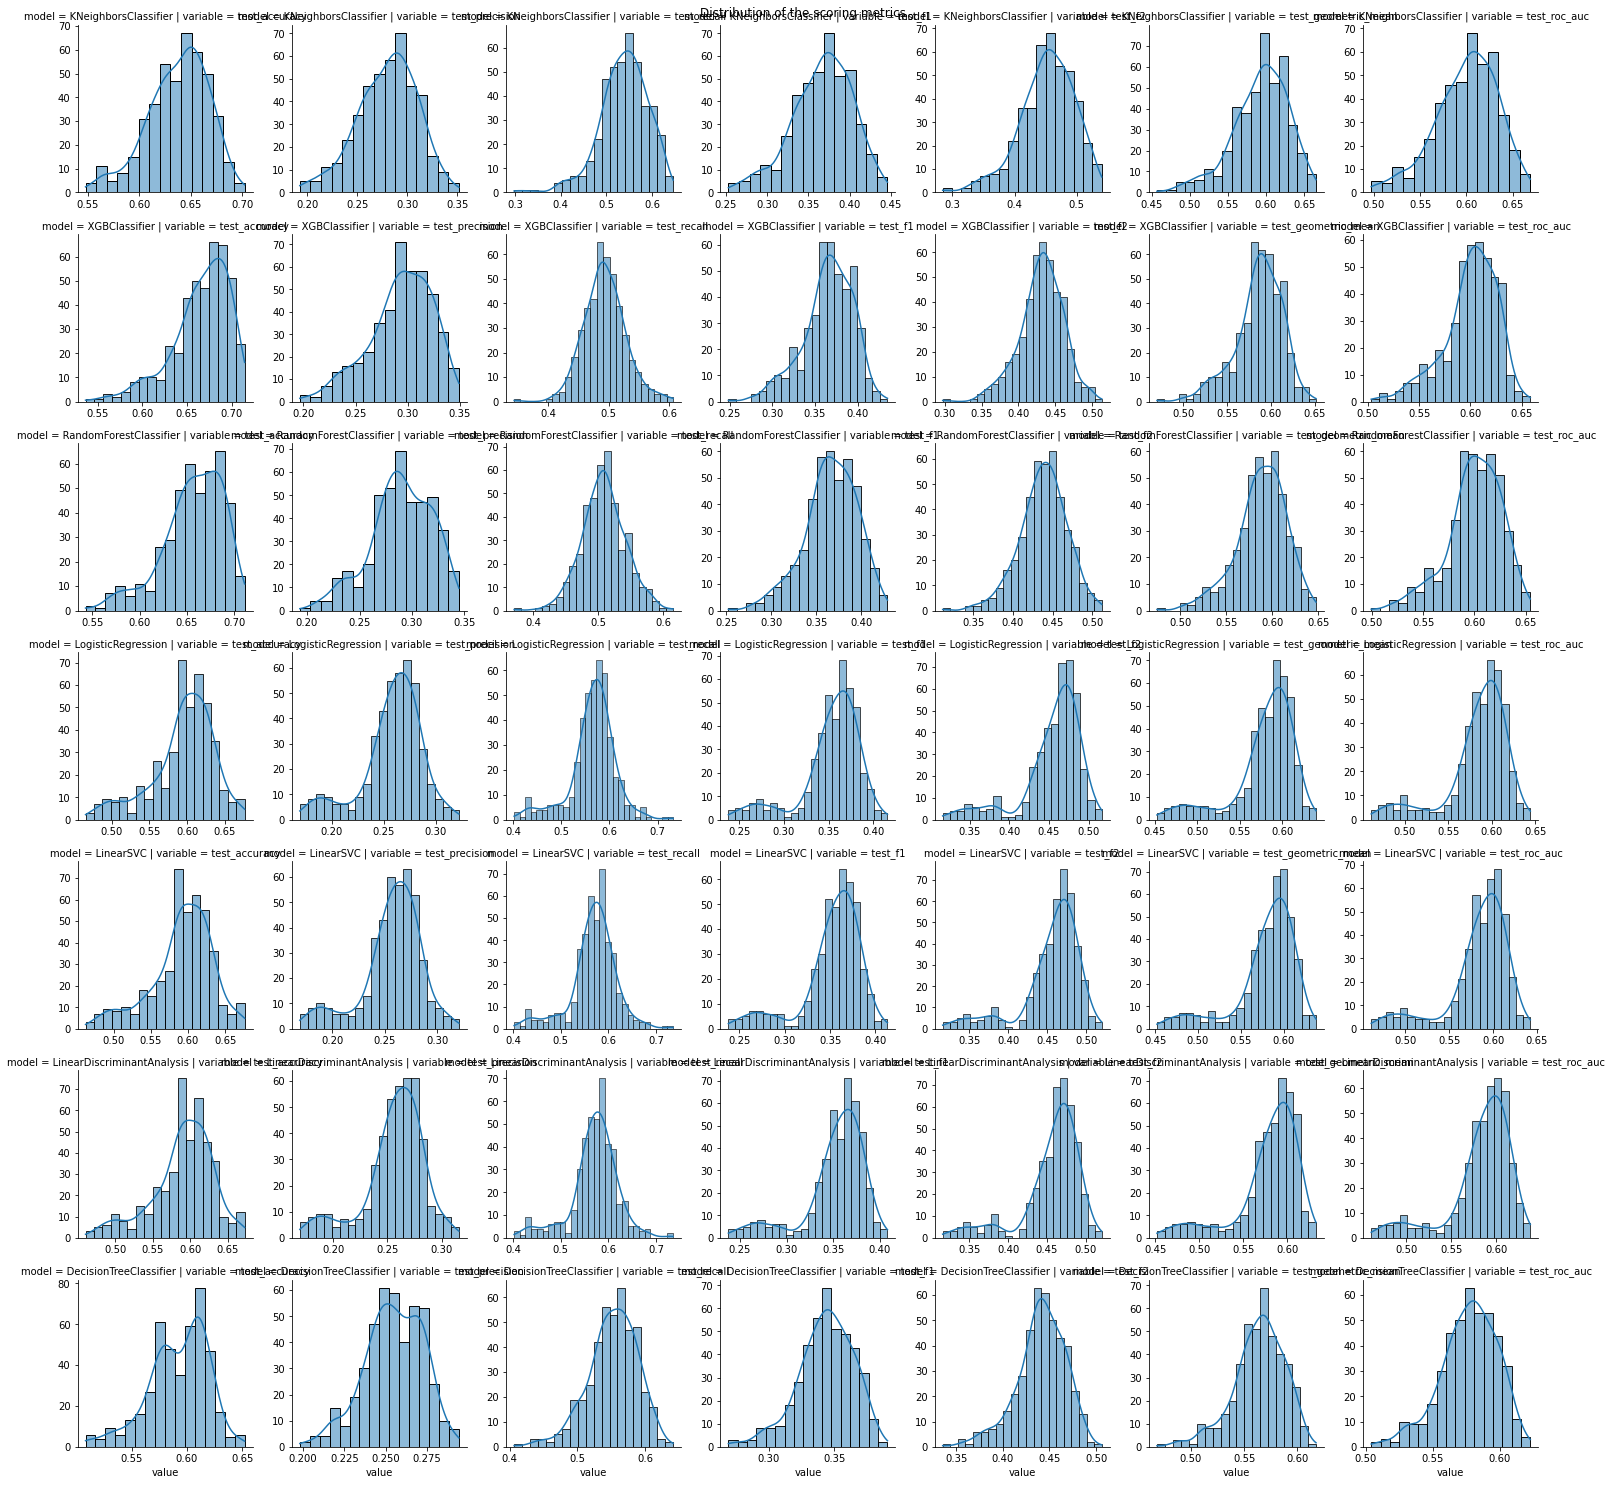

In [43]:
tmp = pd.melt(scores_data, value_vars=scoring_metrics, id_vars='model')
g = sns.FacetGrid(data=tmp, row='model', col='variable', sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of the scoring metrics')
plt.tight_layout()
plt.savefig('figures/scoring_metrics.png', dpi=128)
plt.show()

<a id='performance'></a>
### Performance of the top models

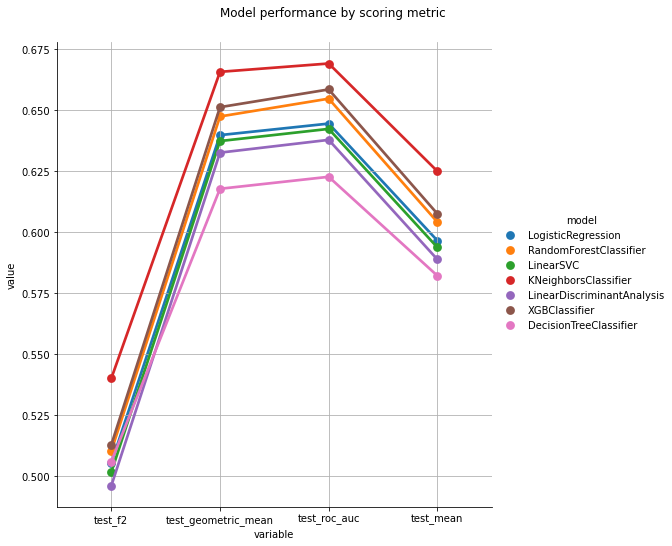

In [35]:
df = scores_data[['model',*test_metrics]].copy()
top = pd.melt(df.groupby(['model']).head(1), 
              id_vars=['model'], value_vars=test_metrics)
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', 
            hue='model', height = 7, order=test_metrics, hue_order=model_list)
plt.suptitle('Model performance by scoring metric', y=1.05)
plt.grid()
plt.savefig('figures/test_performance.png', dpi=128)

<a id='finding'></a>
### Finding the best subset
After removing the docking scores, since they didn't add any relevant information to the classifiers (see [Docking scores and performance increment](#docking)), we select the set of descriptors that yielded the best scores for each classifier.

In [5]:
# Dictionary: key == model_name, value == list of best descriptors
best_subset = {}
activity_label = 'f_activity'

for i, row in scores_data.query('activity_label == @activity_label').groupby('model').head(1).iterrows():
    model_name = row['model']
    best_subset[model_name] = [descriptor for descriptor in descriptors_list if row[descriptor]]
    print(model_name, best_subset[model_name])

KNeighborsClassifier ['NumHAcceptors', 'TPSA', 'LabuteASA']
XGBClassifier ['NumRotatableBonds', 'TPSA']
RandomForestClassifier ['NumRotatableBonds', 'NumHDonors', 'TPSA', 'LabuteASA']
LogisticRegression ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'LabuteASA', 'MolLogP']
LinearSVC ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'LabuteASA', 'MolLogP']
LinearDiscriminantAnalysis ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'LabuteASA', 'MolLogP']
DecisionTreeClassifier ['NumRotatableBonds', 'NumHDonors']


<a id='hyperparameters'></a>
## Fine-tuning hyperparameters

In [6]:
def get_model_and_params(model_name, nsamples):
    if model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier()
        params = {'clf__n_neighbors': [3, 5, 7, int(np.sqrt(nsamples))]}
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        model = XGBClassifier(random_state=13)
        params = {'clf__n_estimators': [40, 100, 200, 500, 1000], 
                 'clf__max_depth': [3, 4, 5, 6, 7, 8, 10, None], 
                 'clf__eta': [0.1, 0.2, 0.3]}
    elif model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(random_state=13)
        params = {'clf__n_estimators': [40, 100, 200, 500, 1000], 
                 'clf__max_depth': [3, 4, 5, 6, 7, 8, 10, None]}

    else:
        from sklearn.tree import DecisionTreeClassifier
        model = DecisionTreeClassifier(random_state=13)
        params = {'clf__max_depth': [3, 4, 5, 6, 7, 8, 10, None]}
        
    return model, params

def grid_search(model, X, y, scaler, param_grid):
    from imblearn.pipeline import Pipeline
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.model_selection import GridSearchCV
    
    pipe = Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', scaler), ('clf', model)])
    grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=RepeatedStratifiedKFold(n_splits=10), 
                        scoring='roc_auc', n_jobs=-1)
    grid.fit(X, y)
    return grid
    
def grid_data(grid, model_name):
    results = []
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        test_score = {'clf': model_name, 'mean_test_score': mean, 'std_test_score': std}
        results.append({**test_score, **params}) # Concatenate two dicts
    
    return pd.DataFrame(results)

def get_grid_df(data, model_list, best_subset, activity_label, scaler):
    grid_df = pd.DataFrame()

    for model_name in model_list:
        if 'Classifier' in model_name:
            subset = best_subset[model_name]
            X = data[subset]
            y = data[activity_label]

            model, param_grid = get_model_and_params(model_name, len(X))
            grid = grid_search(model, X, y, scaler, param_grid)
            print(f'{model_name:<22s} {grid.best_params_}')

            tmp = grid_data(grid, model_name)
            grid_df = pd.concat([grid_df, tmp], axis=0, join='outer')

    grid_df.reset_index(drop=True, inplace=True)
    grid_df.to_csv('grid_search2.csv', index=False)
    return grid_df

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
grid_df = get_grid_df(data, model_list, best_subset, activity_label, scaler)

RandomForestClassifier {'clf__max_depth': 10, 'clf__n_estimators': 1000}
KNeighborsClassifier   {'clf__n_neighbors': 5}
XGBClassifier          {'clf__eta': 0.2, 'clf__max_depth': 3, 'clf__n_estimators': 100}
DecisionTreeClassifier {'clf__max_depth': 5}


In [7]:
grid_df = pd.read_csv('grid_search2.csv')

In [8]:
grid_df.head()

,clf,mean_test_score,std_test_score,clf__max_depth,clf__n_estimators,clf__n_neighbors,clf__eta
0,RandomForestClassifier,0.660217,0.088815,3.0,40.0,NaN,NaN
1,RandomForestClassifier,0.662912,0.088674,3.0,100.0,NaN,NaN
2,RandomForestClassifier,0.665767,0.091020,3.0,200.0,NaN,NaN
3,RandomForestClassifier,0.666573,0.091139,3.0,500.0,NaN,NaN
4,RandomForestClassifier,0.667094,0.090816,3.0,1000.0,NaN,NaN


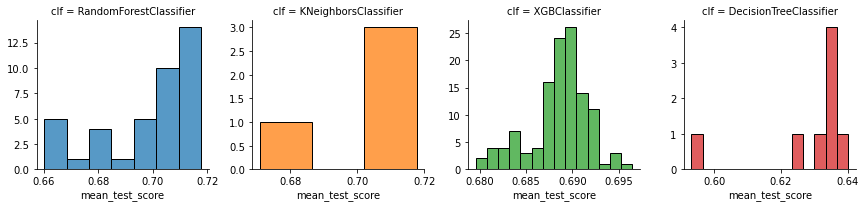

In [10]:
g = sns.FacetGrid(data=grid_df, hue='clf', col='clf', sharex=False, sharey=False)
g.map(sns.histplot,'mean_test_score')

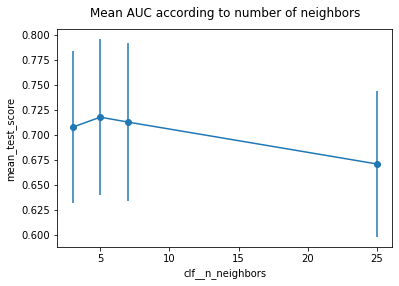

In [11]:
grid_knn = grid_df.query('clf == "KNeighborsClassifier"')
x = grid_knn['clf__n_neighbors']
y = grid_knn['mean_test_score']
plt.errorbar(x, y, yerr=grid_knn['std_test_score'], marker='o')
plt.xlabel('clf__n_neighbors')
plt.ylabel('mean_test_score')
plt.title('KNeighborsClassifier')
plt.title('Mean AUC according to number of neighbors', y=1.03)
plt.show()

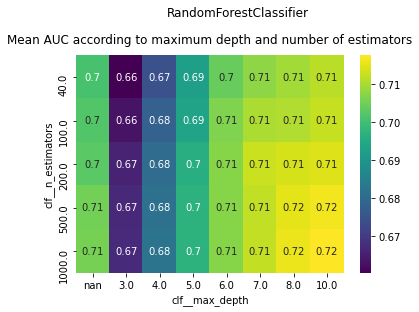

In [12]:
grid_rf = grid_df.query('clf == "RandomForestClassifier"')

table = grid_rf.pivot('clf__n_estimators', 'clf__max_depth', 'mean_test_score')
sns.heatmap(table, cmap='viridis', annot=True)
plt.suptitle('RandomForestClassifier', y=1.05)
plt.title('Mean AUC according to maximum depth and number of estimators', y=1.03)
plt.show()

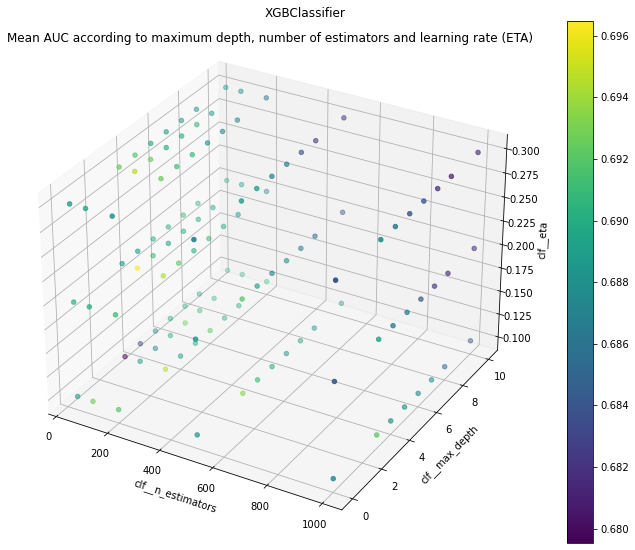

In [13]:
grid_xgb = grid_df.query('clf == "XGBClassifier"')
grid_xgb = grid_xgb.fillna(value=0)

x = grid_xgb['clf__n_estimators']
y = grid_xgb['clf__max_depth']
z = grid_xgb['clf__eta']
c = grid_xgb['mean_test_score']

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12.8, 9.6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=c, cmap='viridis')
fig.colorbar(p)

ax.set_xlabel('clf__n_estimators')
ax.set_ylabel('clf__max_depth')
ax.set_zlabel('clf__eta')
plt.suptitle('XGBClassifier', y=0.9)
plt.title('Mean AUC according to maximum depth, number of estimators and learning rate (ETA)', y=1.03)
plt.show()

<a id='reconstructing'></a>
## Reconstructing the top models

In [9]:
def get_model_opt_by_name(model_name):
    if model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        return XGBClassifier(objective='reg:logistic', n_estimators=100, 
            max_depth=3, eta=0.2, random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        from sklearn.tree import DecisionTreeClassifier
        return DecisionTreeClassifier(max_depth=5, random_state=13)
    elif model_name == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        from sklearn.svm import LinearSVC
        from sklearn.calibration import CalibratedClassifierCV
        # CalibratedClassifierCV is used for applying probability transformation 
        # on top of the SVC outputs, so we can plot the ROC curve
        # https://stackoverflow.com/a/39712590/13131079
        return CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, random_state=13))
    elif model_name == 'LinearDiscriminantAnalysis':
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        return LinearDiscriminantAnalysis(solver='svd')
    else:
        return None

In [10]:
def train_test_scores(X_train, X_test, y_train, y_test, model_fitted):
    from sklearn.metrics import fbeta_score
    from imblearn.metrics import geometric_mean_score
    
    scores_list = []
    y_pred_test = model_fitted.predict(X_test)
    y_pred_train = model_fitted.predict(X_train)
    
    scores_list.append(fbeta_score(y_test, y_pred_test, beta=2))       # test_f2
    scores_list.append(fbeta_score(y_train, y_pred_train, beta=2))     # train_f2
    scores_list.append(geometric_mean_score(y_test, y_pred_test))      # test_geometric_mean
    scores_list.append(geometric_mean_score(y_train, y_pred_train))    # train_geometric_mean
    return scores_list

def get_tpr_KFold(X, y, model_fitted, base_fpr):
    from sklearn.metrics import roc_curve
    
    y_proba = model_fitted.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_proba[:,1])
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    return tpr

def plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name):
    from sklearn.metrics import auc
    # Test mean ROC
    tpr_test = np.mean(tpr_test_list, axis=0)
    tpr_test[-1] = 1.0
    test_auc = auc(base_fpr, tpr_test)
    axis[0].plot(base_fpr, tpr_test, label=f'{model_name}: {test_auc:>.3f}')

    # Training mean ROC
    tpr_train = np.mean(tpr_train_list, axis=0)
    tpr_train[-1] = 1.0
    train_auc = auc(base_fpr, tpr_train)
    axis[1].plot(base_fpr, tpr_train, label=f'{model_name}: {train_auc:>.3f}')
    
    return test_auc, train_auc

def get_scores_list_KFold(X, y, pipe, base_fpr):
    from sklearn.model_selection import RepeatedStratifiedKFold
    
    scores_list_KFold = []
    tpr_train_list = []
    tpr_test_list = []
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=5)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        # Test and training scores
        scores_list_KFold.append(train_test_scores(X_train, X_test, y_train, y_test, model_fitted))
        # Test true positive rate
        tpr_test_list.append(get_tpr_KFold(X_test, y_test, model_fitted, base_fpr))
        # Training true positive rate
        tpr_train_list.append(get_tpr_KFold(X_train, y_train, model_fitted, base_fpr))
    
    return scores_list_KFold, tpr_train_list, tpr_test_list
    
def get_mean_scores(X, y, model, model_name, scaler, axis):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    
    base_fpr = np.linspace(0, 1, 101)
    pipe = make_pipeline(SMOTE(random_state=42), scaler, model)
    scores_list_KFold, tpr_train_list, tpr_test_list = get_scores_list_KFold(X, y, pipe, base_fpr)
    
    # All KFold scores for each metric
    df = pd.DataFrame(scores_list_KFold)
    # Mean of the KFold scores by metric
    mean_scores = list(df.mean()) # column-wise
    
    # Plot mean ROC curve
    test_auc, train_auc = plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name)
    # Append mean AUC
    mean_scores.append(test_auc)
    mean_scores.append(train_auc)
    mean_scores.append(model_name)
    return mean_scores

<a id='roc_curves'></a>
### ROC curves

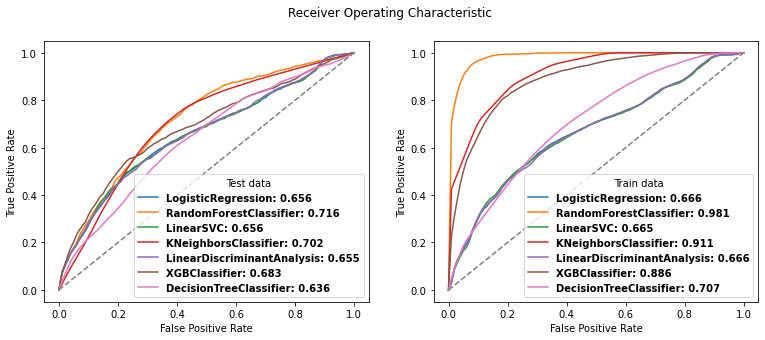

,test_f2,train_f2,test_geometric_mean,train_geometric_mean,test_roc_auc,train_roc_auc,model,test_mean,train_mean
0,0.479686,0.497784,0.616678,0.633961,0.655538,0.666482,LogisticRegression,0.583967,0.599409
1,0.463496,0.899232,0.622356,0.934167,0.716464,0.981376,RandomForestClassifier,0.600772,0.938258
2,0.482798,0.489753,0.619462,0.628072,0.655987,0.665103,LinearSVC,0.586082,0.594309
3,0.540015,0.750466,0.664738,0.822578,0.701945,0.911174,KNeighborsClassifier,0.635566,0.828073
4,0.473852,0.487680,0.613079,0.626668,0.655308,0.665836,LinearDiscriminantAnalysis,0.580746,0.593395
5,0.507282,0.721204,0.648190,0.809193,0.683193,0.886048,XGBClassifier,0.612888,0.805482
6,0.489773,0.554899,0.586984,0.639356,0.635602,0.706983,DecisionTreeClassifier,0.570786,0.633746


In [11]:
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))
# List of scores for the top models
scores_list = []

for model_name in model_list:
    subset = [descriptor for descriptor in best_subset[model_name] if descriptor not in docking_list]
    y = data[activity_label]
    X = data[subset]
    scaler = StandardScaler()
    model = get_model_opt_by_name(model_name)
    model_scores = get_mean_scores(X, y, model, model_name, scaler, axis=ax)
    scores_list.append(model_scores)

columns = ['test_f2', 'train_f2', 'test_geometric_mean', 'train_geometric_mean', 
           'test_roc_auc', 'train_roc_auc', 'model']
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics[:-1]].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics[:-1]].mean(axis=1)

for i in range(2):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
font_prop = {'weight':'bold'}
ax[0].legend(title='Test data', prop=font_prop)
ax[1].legend(title='Train data', prop=font_prop)

plt.suptitle('Receiver Operating Characteristic')
plt.savefig('figures/roc_curve_KFold.png', dpi=128)
plt.show()

top_scores

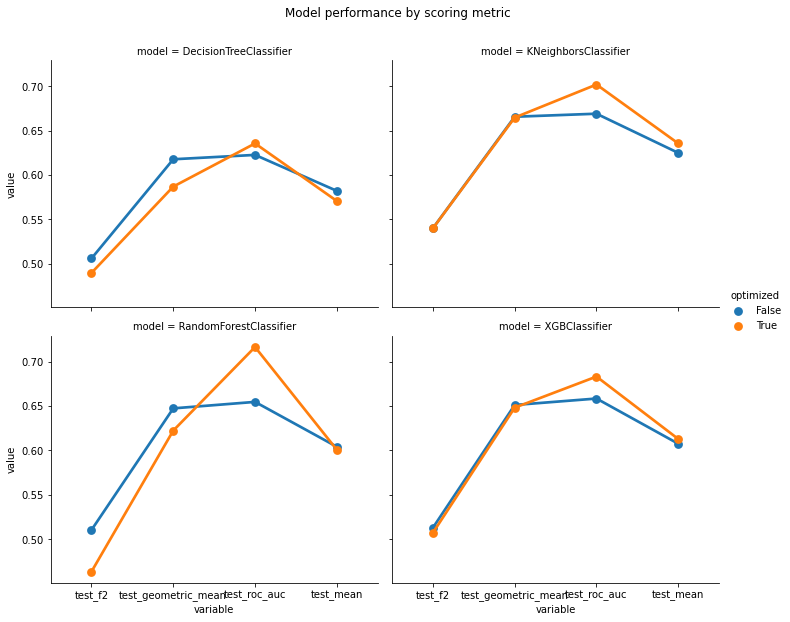

In [60]:
df1 = scores_data[['model','test_f2','test_geometric_mean','test_roc_auc','test_mean']].groupby('model').head(1).sort_values('model')
df2 = top_scores[['model','test_f2','test_geometric_mean','test_roc_auc','test_mean']].groupby('model').head(1).sort_values('model')

df1['optimized'] = False
df2['optimized'] = True

df = pd.concat([df1, df2])
df = df.query('model == "RandomForestClassifier" or model == "KNeighborsClassifier" or model == "XGBClassifier" or model == "DecisionTreeClassifier"')

compare = pd.melt(df, id_vars=['model','optimized'], value_vars=['test_f2','test_geometric_mean','test_roc_auc','test_mean'])

sns.catplot(kind='point', data=compare, x='variable', y='value', col='model', hue='optimized', col_wrap=2, height=4, aspect=1.25)
plt.suptitle('Model performance by scoring metric', y=1.05)
plt.savefig('performance-increment.png')

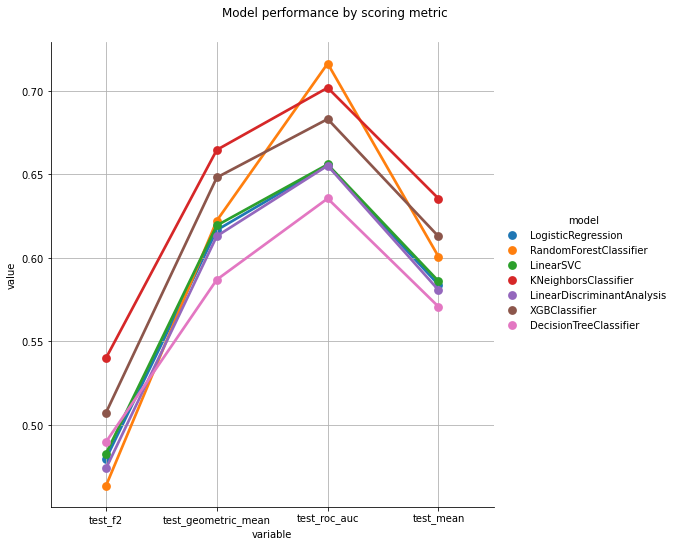

In [61]:
df = top_scores[['model',*test_metrics]].copy()
top = pd.melt(df.groupby(['model']).head(1), 
              id_vars=['model'], value_vars=test_metrics)
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', 
            hue='model', height = 7, order=test_metrics, hue_order=model_list)
plt.suptitle('Model performance by scoring metric', y=1.05)
plt.grid()

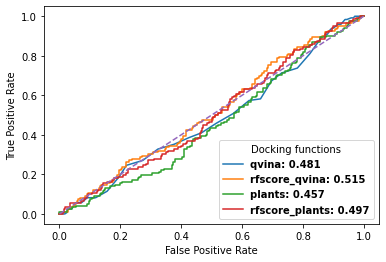

In [27]:
from sklearn.metrics import roc_curve, auc

# Plotting ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data[activity_label].values, data[SF].values)
    plt.plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')
    
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
font_prop = {'weight':'bold'}
plt.legend(title='Docking functions', loc='lower right', prop=font_prop)
plt.savefig('figures/docking_roc_curve.png', dpi=128)

<a id='supplementary'></a>
## Supplementary data
<a id='comparing'></a>
### Comparing classifiers

In [28]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(scores_data.groupby(['model','activity_label']).describe())

test_accuracy                      \
                                                  count      mean       std   
model                      activity_label                                     
DecisionTreeClassifier     f_activity             437.0  0.592012  0.026962   
KNeighborsClassifier       f_activity             437.0  0.637673  0.029447   
LinearDiscriminantAnalysis f_activity             437.0  0.589998  0.040553   
LinearSVC                  f_activity             437.0  0.591669  0.041299   
LogisticRegression         f_activity             437.0  0.594569  0.041530   
RandomForestClassifier     f_activity             437.0  0.656525  0.032143   
XGBClassifier              f_activity             437.0  0.665716  0.032200   

                                                                         \
                                                min       25%       50%   
model                      activity_label                                 
DecisionTreeClassifier     f_activity      0.507862  0.575810  0.596019   
KNeighborsClassifier       f_activity      0.547761  0.619380  0.641305   
LinearDiscriminantAnalysis f_activity      0.460741  0.572621  0.595469   
LinearSVC                  f_activity      0.462195  0.573797  0.596761   
LogisticRegression         f_activity      0.465234  0.578518  0.600419   
RandomForestClassifier     f_activity      0.543013  0.639682  0.660015   
XGBClassifier              f_activity      0.536607  0.650927  0.672471   

                                                              test_precision  \
                                                75%       max          count   
model                      activity_label                                      
DecisionTreeClassifier     f_activity      0.611674  0.652296          437.0   
KNeighborsClassifier       f_activity      0.658786  0.702355          437.0   
LinearDiscriminantAnalysis f_activity      0.616918  0.672226          437.0   
LinearSVC                  f_activity      0.619040  0.676094          437.0   
LogisticRegression         f_activity      0.622286  0.676255          437.0   
RandomForestClassifier     f_activity      0.681678  0.710727          437.0   
XGBClassifier              f_activity      0.689993  0.714370          437.0   

                                                                         \
                                               mean       std       min   
model                      activity_label                                 
DecisionTreeClassifier     f_activity      0.254655  0.017665  0.198070   
KNeighborsClassifier       f_activity      0.280040  0.029831  0.192722   
LinearDiscriminantAnalysis f_activity      0.256240  0.028035  0.169131   
LinearSVC                  f_activity      0.256842  0.028558  0.169190   
LogisticRegression         f_activity      0.257923  0.029050  0.169303   
RandomForestClassifier     f_activity      0.289498  0.029356  0.193103   
XGBClassifier              f_activity      0.293396  0.029998  0.196624   

                                                                         \
                                                25%       50%       75%   
model                      activity_label                                 
DecisionTreeClassifier     f_activity      0.244161  0.255402  0.268382   
KNeighborsClassifier       f_activity      0.260545  0.283245  0.301192   
LinearDiscriminantAnalysis f_activity      0.245295  0.260398  0.274263   
LinearSVC                  f_activity      0.245837  0.260920  0.274805   
LogisticRegression         f_activity      0.246525  0.263172  0.276524   
RandomForestClassifier     f_activity      0.272819  0.290537  0.312560   
XGBClassifier              f_activity      0.276521  0.296572  0.316038   

                                                    test_recall            \
                                                max       count      mean   
model                      activity_label  

<a id='top_classifiers'></a>
### Performance of the top classifiers

Text(0.5, 1.05, 'Model performance by scoring metric')

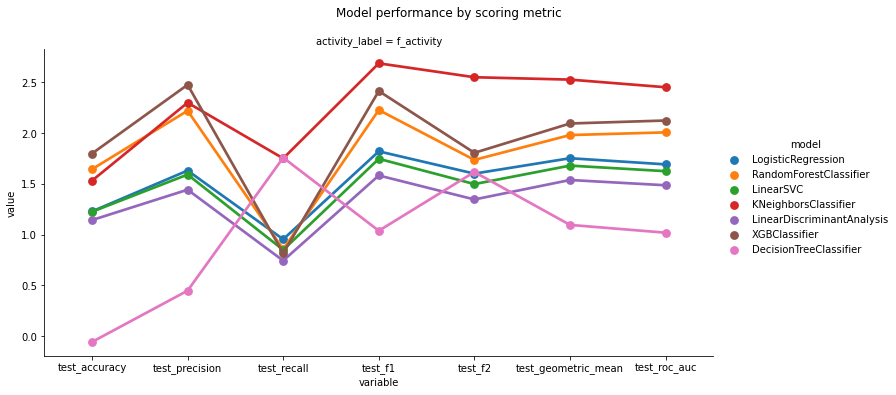

In [29]:
df = scores_data[['activity_label','model',*scoring_metrics]].copy()
df[scoring_metrics] = StandardScaler().fit_transform(df[scoring_metrics])
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), 
              id_vars=['activity_label','model'], value_vars=scoring_metrics)
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', 
            hue='model', row='activity_label', aspect=2, order=scoring_metrics, hue_order=model_list)
plt.suptitle('Model performance by scoring metric', y=1.05)

<a id='docking'></a>
### Docking scores and performance increment

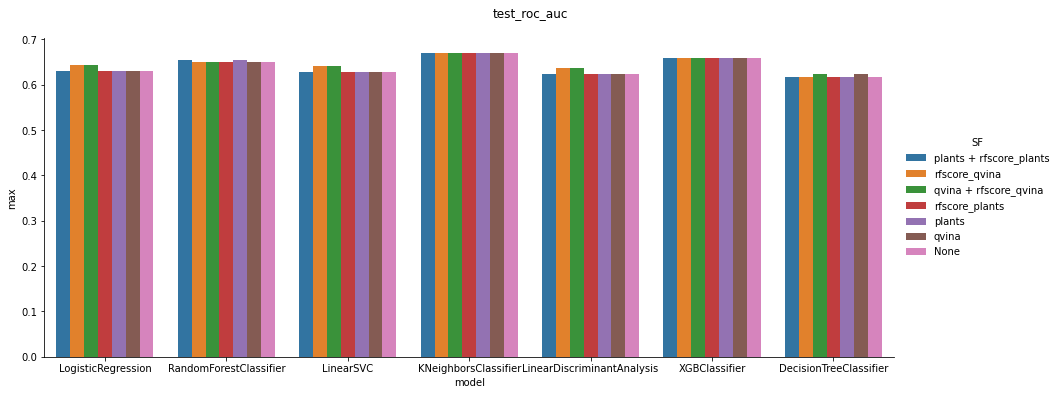

In [30]:
'''
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]
'''

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0'
                      ).groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

sns.catplot(kind='bar', data=df, x='model', y='max', hue='SF', orient='v', aspect=2.5, order=model_list)
plt.suptitle('test_roc_auc', y=1.05)
plt.show()

The barplot above indicates that the performance scores don't increase when the docking scores are taken into account, thus they don't add relevant information for the classifiers. 

<a id='top_descriptors'></a>
### Top descriptors

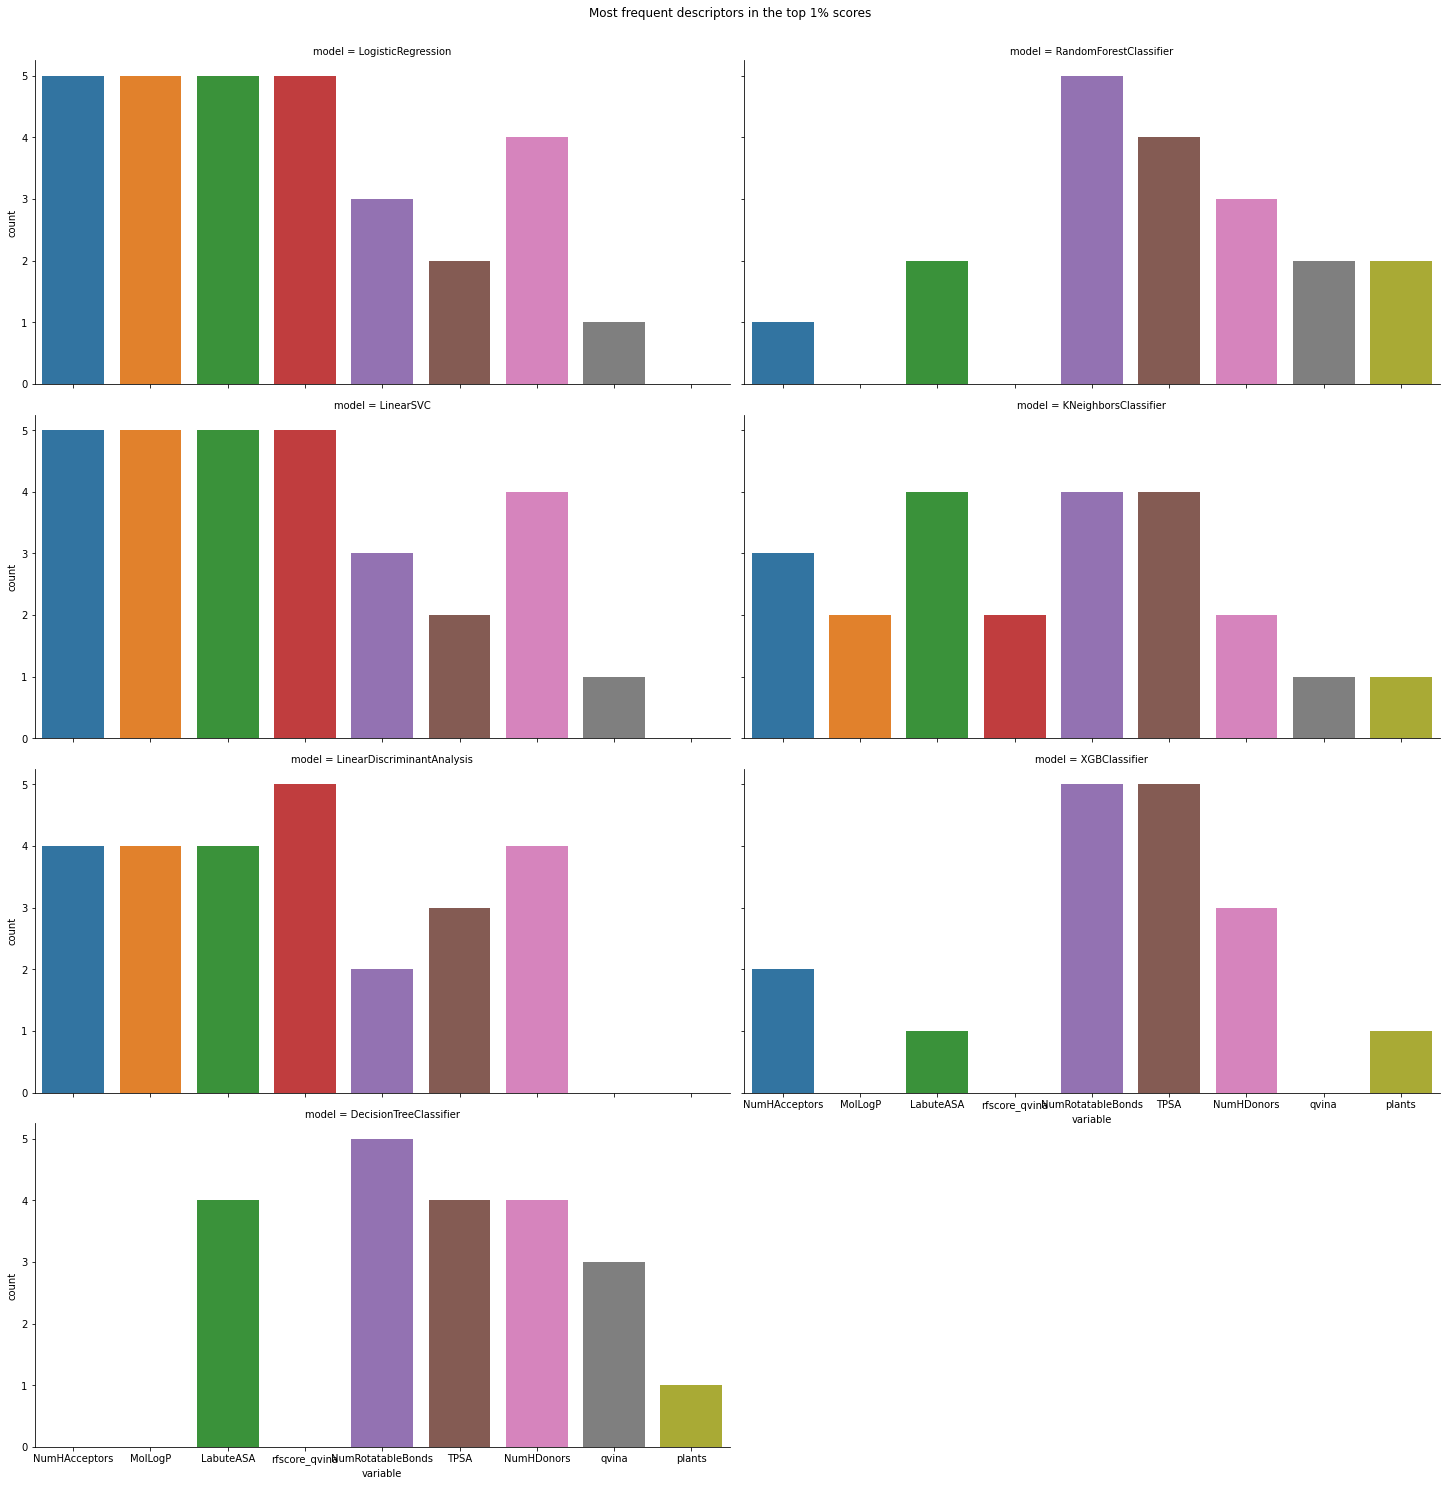

In [16]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=['activity_label','model',*test_metrics], value_vars=trainset, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

g = sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', 
                col_order=model_list, col_wrap=2, aspect=2)

# Set title
plt.suptitle('Most frequent descriptors in the top 1% scores', y=1.02)
plt.show()

<a id='saving'></a>
### Saving the top 3 models

In [22]:
def save_pickle(model_fitted, model_name):
    # Serialize model
    import pickle
    import os

    if not os.path.isdir('pickle'):
        os.mkdir('pickle')
    with open(f'pickle/{model_name}2.pickle', 'wb') as file:
        pickle.dump(model_fitted, file)
        
def save_model(model, subset, data):
    from sklearn.preprocessing import StandardScaler
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    
    y_train = data[activity_label]
    X_train = data[subset]
    pipe = make_pipeline(SMOTE(random_state=42), StandardScaler(), model)

    model_fitted = pipe.fit(X_train, y_train)
    save_pickle(model_fitted, model_name)
    return model_fitted

In [23]:
for model_name in ['RandomForestClassifier','KNeighborsClassifier','XGBClassifier']:
    model = get_model_opt_by_name(model_name)
    subset = [descriptor for descriptor in best_subset[model_name] if descriptor not in docking_list]
    print(f'{model_name}: {subset}')
    model_fitted = save_model(model, subset, data)

RandomForestClassifier: ['NumRotatableBonds', 'NumHDonors', 'TPSA', 'LabuteASA']
KNeighborsClassifier: ['NumHAcceptors', 'TPSA', 'LabuteASA']
XGBClassifier: ['NumRotatableBonds', 'TPSA']
